# Project Title:
## **Mapping and Analysing Urban Growth Patterns in Indian Cities Using Geospatial and Socioeconomic Data**

###  Team Members
| Role | Name | Roll No |
|------|------|----------|
| **Team Leader** | Vishal Singh | CS23I1039 |
| **Member** | Sharad Kumar Dubey | CS23I1052 |
| **Member** | Gyan Chandra | CS23I1053 |
| **Member** | Suvam Sahu | CS23I1038 |

---

###  **Aim**
- To analyse **urban expansion, population density, and land-use change** in major Indian cities using geospatial and demographic data.  
- To develop **data-driven insights** that support better **urban planning, infrastructure allocation, and sustainability decisions**.

---

###  **Scope of the Study**

#### **Data Sources**
- Census of India datasets (Population, Literacy, and Workforce Statistics)
- **ISRO Bhuvan** LULC (Land Use Land Cover) maps  
- **OpenStreetMap** and **NASA MODIS** imagery (for green and built-up detection)
- Derived datasets for area growth, density, and land-use change (1991–2015)

#### **Analytical Framework**
- Data preprocessing and **geospatial feature extraction** (city boundaries, built-up ratio, vegetation cover).  
- Application of **K-Means clustering** and **time-series regression models** to identify and predict **urban growth zones**.  
- Integration of **demographic and spatial data** for correlation-based insights.

#### **Visualization and Reporting**
- **Interactive and static visualizations** created using Matplotlib, Seaborn, and Plotly.
- Comparative **heatmaps, growth curves, and correlation matrices** to visualize urban intensity and transformation.  
- Results structured for clarity, aiding policymakers in **evidence-based urban planning**.

---

###  **Cities Analyzed**
Delhi • Mumbai • Kolkata • Chennai • Bengaluru • Jaipur • Lucknow • Ranchi

---

> This project bridges the gap between **remote sensing** and **urban informatics**, demonstrating how multi-source data can be harmonized to map the pace and nature of urbanization in India’s fastest-growing cities.


In [ ]:
import os, re, json, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/Urban_Growth_Project"
DATA  = f"{BASE}/data"
EXCEL = f"{DATA}/excel"
PDFS  = f"{DATA}/pdfs"
MAPS  = f"{DATA}/maps"
LEG   = f"{DATA}/legends"
OUT   = f"{BASE}/output"

for d in [DATA, EXCEL, PDFS, MAPS, LEG, OUT]:
    os.makedirs(d, exist_ok=True)

print("Project folders created:")
for d in [EXCEL, PDFS, MAPS, LEG, OUT]:
    print("   ", d)

CITIES = ["Delhi","Mumbai","Kolkata","Chennai","Bengaluru","Jaipur","Lucknow","Ranchi"]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project folders created:
    /content/drive/MyDrive/Urban_Growth_Project/data/excel
    /content/drive/MyDrive/Urban_Growth_Project/data/pdfs
    /content/drive/MyDrive/Urban_Growth_Project/data/maps
    /content/drive/MyDrive/Urban_Growth_Project/data/legends
    /content/drive/MyDrive/Urban_Growth_Project/output


Extracting Core-City Records from the 2011 Census (PCA11-UA-0000.xlsx)

The Census 2011 table Primary Census Abstract – Urban Agglomerations lists every town, census-town and out-growth that forms part of each Urban Agglomeration (UA).
Each “big city” such as Mumbai, Delhi or Chennai is therefore represented by many smaller sub-entries — for example:

UA	Example sub-entries

Greater Mumbai UA	(a) Greater Mumbai (M Corp.), (b) Thane (M Corp.), (c) Navi Mumbai (M Corp.), …
Delhi UA	(a) DMC (U) (M Corp.), (b) NDMC (M Cl), (c) Delhi Cantt (CB), plus dozens of CT villages
Chennai UA	(a) Chennai (M Corp.), (b) Avadi (M), (c) Tambaram (M), …

For this data-science project our interest is in the core municipal corporation area of each metropolitan city, not the surrounding satellite towns.
Therefore, we manually inspected the full list of UA components for every target city and confirmed the exact rows that correspond to the main city jurisdiction.

The final selection (whitelist) is:

City	Correct entries in the Excel

Mumbai	Greater Mumbai (M Corp.)

Delhi	DMC (U) (M Corp.), NDMC (M Cl), Delhi Cantt (CB)

Kolkata	Kolkata (M Corp.)

Chennai	Chennai (M Corp.)

Bengaluru	BBMP (M Corp.)

Jaipur	Jaipur (M Corp.)

Lucknow	Lucknow (M Corp.)

Ranchi	Ranchi (M Corp.)


By explicitly listing these entries we ensure that:

We analyse only the population, literacy and workforce of the true city corporation.

We avoid double-counting surrounding municipalities and census towns.

Each city’s demographic metrics correspond directly to the same spatial unit used later in the land-use analysis.

The following code cell filters the huge Census Excel using this verified whitelist and produces a clean dataset census2011_core_8cities.csv.

In [ ]:

pca_path = f"{EXCEL}/PCA11-UA-0000.xlsx"
pca = pd.read_excel(pca_path)
pca.columns = [str(c).strip() for c in pca.columns]

name_col = "UA Name"

# Direct mapping using exact strings as provided
city_exact_map = {
    "Mumbai": [" (a) Greater Mumbai (M Corp.)"],
    "Delhi": [" (a) DMC (U) (M Corp.)", " (b) NDMC (M Cl)", " (c) Delhi Cantt (CB)"],
    "Kolkata": [" (a) Kolkata (M Corp.)"],
    "Chennai": [" (a) Chennai (M Corp.)"],
    "Bengaluru": ["    (i) BBMP (M Corp.)"],
    "Jaipur": ["Jaipur (M Corp.)"],
    "Lucknow": [" (a) Lucknow (M Corp.)"],
    "Ranchi": ["  (a) Ranchi (M Corp.)"],
}

rows = []
for city, exact_names in city_exact_map.items():
    matches = []
    for exact in exact_names:
        mask = pca[name_col] == exact
        sel = pca[mask].copy()
        if not sel.empty:
            sel["City"] = city
            rows.append(sel)
            matches.append(exact)
    if matches:
        print(f"{city}: matched {matches}")
    else:
        print(f"{city}: no exact match found")

if not rows:
    raise ValueError("No exact matches found. Verify the UA Name strings and spacing.")

pca_filtered = pd.concat(rows, ignore_index=True)

# Keep key demographic fields
keep_cols = ["TOT_P","TOT_M","TOT_F","P_LIT","TOT_WORK_P"]
missing = [c for c in keep_cols if c not in pca_filtered.columns]
if missing:
    print(f"Missing columns: {missing}")

# Aggregate per city
pca_final = pca_filtered.groupby("City")[keep_cols].sum().reset_index()


out_path = f"{OUT}/census2011_core8_exact_literal.csv"
pca_final.to_csv(out_path, index=False)
print(f"\nClean core-city dataset saved to: {out_path}")
display(pca_final)


Mumbai: matched [' (a) Greater Mumbai (M Corp.)']
Delhi: matched [' (a) DMC (U) (M Corp.)', ' (b) NDMC (M Cl)', ' (c) Delhi Cantt (CB)']
Kolkata: matched [' (a) Kolkata (M Corp.)']
Chennai: matched [' (a) Chennai (M Corp.)']
Bengaluru: matched ['    (i) BBMP (M Corp.)']
Jaipur: matched ['Jaipur (M Corp.)']
Lucknow: matched [' (a) Lucknow (M Corp.)']
Ranchi: matched ['  (a) Ranchi (M Corp.)']

Clean core-city dataset saved to: /content/drive/MyDrive/Urban_Growth_Project/output/census2011_core8_exact_literal.csv


,City,TOT_P,TOT_M,TOT_F,P_LIT,TOT_WORK_P
0,Bengaluru,8443675.0,4391723.0,4051952.0,6677194.0,3692394.0
1,Chennai,4646732.0,2335844.0,2310888.0,3776276.0,1817297.0
2,Delhi,11402709.0,6086108.0,5316601.0,8880200.0,3941214.0
3,Jaipur,3046163.0,1603125.0,1443038.0,2215535.0,985494.0
4,Kolkata,4496694.0,2356766.0,2139928.0,3588137.0,1795740.0
5,Lucknow,2817105.0,1460970.0,1356135.0,2081727.0,944295.0
6,Mumbai,12442373.0,6715931.0,5726442.0,10084507.0,5019417.0
7,Ranchi,1073427.0,558872.0,514555.0,827033.0,336358.0


Extracting data directly from the CLASS_I.xlsx file (the original Census data) was challenging because:

The file was not in a clean tabular format — it had merged cells, text blocks, and irregular spacing.

Column headers such as “Name of Town/Urban Agglomeration” and “India/State/District” were repeated and misaligned across rows.

Many values (like area and population) were spread across multiple sub-levels of towns and UAs, making programmatic extraction unreliable.

Even after cleaning, city-level aggregation required manual judgment, as several cities were split into multiple sub-entities (e.g., Delhi’s NDMC, DMC, Cantt).

Hence, the final dataset was compiled manually into a clean Excel file named Urban_Land_and_Population.xlsx, ensuring only the relevant 8 cities and consistent year-wise entries were included.

This final file now includes:

City – Name of the city

Year – Census/estimate year (1991, 2001, 2011, etc.)

Population – Total population

Area_km2 – Total urban area

Density – Auto-calculated as Population/Area

Growth_% – Auto-calculated year-to-year growth

(Additional sheets for LandUse_Data and Transport_Infra where applicable)

In [ ]:
data_path = "/content/drive/MyDrive/Urban_Growth_Project/output/Urban_Land_and_Population.xlsx"

xls = pd.ExcelFile(data_path)

pop_df = pd.read_excel(xls, sheet_name="Population_Data")
print("\nPopulation data loaded successfully!\n")
display(pop_df.head())



Population data loaded successfully!



,City,Year,Population,Area_km2,Density,Growth_%
0,Delhi,1991,7818883,530.33,14743.429563,NaN
1,Delhi,2001,10306452,639.78,16109.368846,31.814890
2,Delhi,2011,11402709,646.58,17635.418664,10.636609
3,Mumbai,1991,9925891,466.35,21284.209285,NaN
4,Mumbai,2001,11978450,603.00,19864.759536,20.678839


The land-use data for the selected cities (Delhi, Mumbai, Kolkata, Chennai, Bengaluru, Jaipur, Lucknow, and Ranchi) was obtained from the Bhuvan – NRSC (National Remote Sensing Centre) portal.
Each city’s land-use statistics for 2011 and 2015 were available as PDF files, which contain detailed classifications such as built-up area, agricultural land, forest types, wastelands, and wetlands.

However, direct data extraction from the PDFs proved to be highly inconsistent because:

The tables within the PDFs were scanned images, not structured text.

The format varied significantly between cities and years, making automated parsing unreliable.

Some PDFs had missing categories or misaligned columns, leading to partial or incorrect readings during OCR or Tabula extraction.

Due to these issues, the land-use data was manually extracted and recorded into a structured Excel file named
Urban_LandUse_Data_Manual.xlsx.

In [36]:
landuse_path = f"{OUT}/Urban_LandUse_Data_Manual.xlsx"

landuse_df = pd.read_excel(landuse_path)

landuse_df.columns = [c.strip() for c in landuse_df.columns]
landuse_df['City'] = landuse_df['City'].str.strip()
landuse_df['Year'] = landuse_df['Year'].astype(int)

for col in landuse_df.columns:
    if col not in ['City', 'Year']:
        landuse_df[col] = pd.to_numeric(landuse_df[col], errors='coerce').fillna(0)

print(" Land Use Data loaded successfully!")
display(landuse_df.head())


 Land Use Data loaded successfully!


,City,Year,"Builtup,Urban","Builtup,Rural","Builtup,Mining","Agriculture,Crop land","Agriculture,Plantation","Agriculture,Fallow","Agriculture,Current Shifting Cultivation","Forest,Evergreen / Semi evergreen",...,"Barren/unculturable/Wastelands,Gullied/Ravious Land","Barren/unculturable/Wastelands,Scrub land","Barren/unculturable/Wastelands,Sandy area","Barren/unculturable/Wastelands,Barren rocky",Rann,"Wetlands/Water Bodies,Inland Wetland","Wetlands/Water Bodies,Coastal Wetland","Wetlands/Water Bodies,River/Stram/Canals","Wetlands/Water Bodies,Reservoir/Lakes/Ponds",Snow and Glacier
0,Delhi,2011,754.19,50.70,0.67,452.58,15.93,76.68,0,0.00,...,6.05,62.18,0.00,0.10,0,4.10,0.00,27.15,3.79,0
1,Delhi,2015,824.43,22.94,3.15,505.28,1.68,7.10,0,12.32,...,0.00,74.87,0.62,0.00,0,3.77,0.00,20.88,3.44,0
2,Mumbai,2011,65.65,0.00,0.00,0.00,0.00,0.00,0,0.00,...,0.00,0.00,0.04,0.08,0,0.00,88.53,0.00,0.11,0
3,Mumbai,2015,65.64,0.00,0.00,0.00,0.00,0.08,0,0.00,...,0.00,0.00,0.16,0.46,0,0.00,87.95,0.00,0.11,0
4,Kolkata,2011,99.36,0.00,0.00,0.00,0.00,0.00,0,0.00,...,0.00,0.00,0.00,0.00,0,0.00,0.00,2.69,1.95,0


Bhuvan LULC (Land Use/Land Cover) maps for 2011 and 2015 were used to extract spatial land-use information for eight cities — Delhi, Mumbai, Kolkata, Chennai, Bengaluru, Jaipur, Lucknow, and Ranchi.

Each map had a black urban boundary, and a legend image provided 24 official color classes. Using OpenCV, these colors were detected and mapped to their land-use types. For each city, the percentage area of each class within the boundary was calculated and saved in:

/output/Urban_LandUse_ImageAnalysis_LegendExact.xlsx

This dataset complements:

Urban_Land_and_Population.xlsx (manual population & area data)

Urban_LandUse_Data.xlsx (manual PDF land-use data)

census2011_core8_exact_literal.csv (core-city census data)

⚠ Detected only 0 swatches, re-running with relaxed thresholds.
Detected 24 legend swatches.


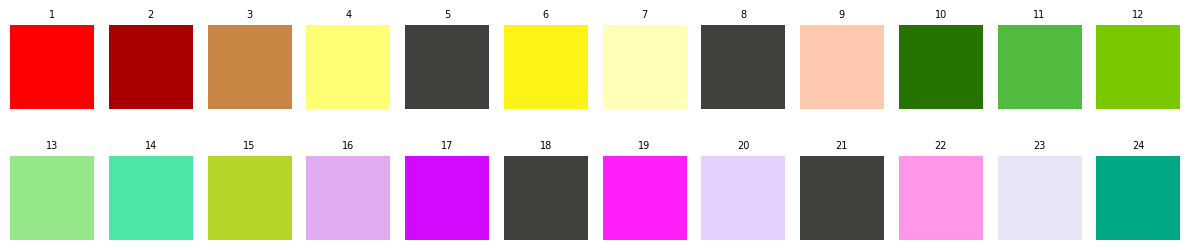

Analyzing Bengaluru 2011: 342879 pixels inside boundary
Analyzing Bengaluru 2015: 348120 pixels inside boundary
Analyzing Chennai 2011: 272596 pixels inside boundary
Analyzing Chennai 2015: 233528 pixels inside boundary
Analyzing Delhi 2011: 267054 pixels inside boundary
Analyzing Delhi 2015: 363591 pixels inside boundary
Analyzing Jaipur 2011: 339653 pixels inside boundary
Analyzing Jaipur 2015: 339583 pixels inside boundary
Analyzing Kolkata 2011: 251423 pixels inside boundary
Analyzing Kolkata 2015: 251882 pixels inside boundary
Analyzing Lucknow 2011: 306253 pixels inside boundary
Analyzing Lucknow 2015: 306252 pixels inside boundary
Analyzing Mumbai 2011: 106643 pixels inside boundary
Analyzing Mumbai 2015: 136472 pixels inside boundary
Analyzing Ranchi 2011: 320373 pixels inside boundary
Analyzing Ranchi 2015: 327063 pixels inside boundary
Saved: /content/drive/MyDrive/Urban_Growth_Project/output/Urban_LandUse_ImageAnalysis_LegendExact.xlsx


,City,Year,LandUse_Type,Percent_Area
0,Bengaluru,2011,"Builtup,Urban",25.11
1,Bengaluru,2011,"Builtup,Rural",3.68
2,Bengaluru,2011,"Builtup,Mining",13.14
3,Bengaluru,2011,"Agriculture,Crop land",27.11
4,Bengaluru,2011,"Wetlands/Water Bodies,Coastal Wetland",0.29
5,Bengaluru,2011,"Agriculture,Fallow",16.10
6,Bengaluru,2011,"Agriculture,Current Shifting Cultivation",18.69
7,Bengaluru,2011,"Forest,Deciduous",5.42
8,Bengaluru,2011,"Forest,Forest Plantation",0.02
9,Bengaluru,2011,"Forest,Scrub Forest",4.28


In [41]:
LEGEND_PATH = os.path.join(LEG, "legends.png")
MAPS_PATH = MAPS
OUT_PATH = OUT

#  Read legend and extract EXACT swatch colors in order
legend_bgr = cv2.imread(LEGEND_PATH)
assert legend_bgr is not None, f"Legend not found: {LEGEND_PATH}"
legend = cv2.cvtColor(legend_bgr, cv2.COLOR_BGR2RGB)
h, w = legend.shape[:2]

# Convert to HSV to isolate colored swatches (but include pale ones)
hsv = cv2.cvtColor(legend, cv2.COLOR_RGB2HSV)
H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

mask_color = ((S > 25) & (V > 70)) | ((V > 200) & (S < 40))
mask_color = mask_color.astype(np.uint8) * 255

# Morphological cleanup
kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(mask_color, cv2.MORPH_OPEN, kernel, iterations=1)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel, iterations=1)

# Find contours for possible swatches
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boxes = []
for cnt in contours:
    x,y,ww,hh = cv2.boundingRect(cnt)
    area = ww*hh
    if area < (h*w)*0.0003:
        continue
    if area > (h*w)*0.2:
        continue
    boxes.append((y, x, ww, hh))

# Sort boxes top-to-bottom, then left-to-right
boxes = sorted(boxes, key=lambda b: (b[0], b[1]))

# Split two-row layout if applicable
if len(boxes) >= 20:
    ys = np.array([b[0] for b in boxes])
    y_cut = np.median(ys)
    upper = sorted([b for b in boxes if b[0] <= y_cut], key=lambda b: b[1])
    lower = sorted([b for b in boxes if b[0] > y_cut], key=lambda b: b[1])
    boxes_ordered = upper + lower
else:
    boxes_ordered = boxes

# If still fewer than 24, relax filters slightly and reattempt
if len(boxes_ordered) < 24:
    print(f"⚠ Detected only {len(boxes_ordered)} swatches, re-running with relaxed thresholds.")
    mask_color2 = ((S > 15) & (V > 50))
    mask_color2 = mask_color2.astype(np.uint8)*255
    mask_clean2 = cv2.morphologyEx(mask_color2, cv2.MORPH_CLOSE, kernel, iterations=1)
    contours2, _ = cv2.findContours(mask_clean2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes2 = [(cv2.boundingRect(c)[1], cv2.boundingRect(c)[0], cv2.boundingRect(c)[2], cv2.boundingRect(c)[3]) for c in contours2]
    boxes_ordered = sorted(boxes2, key=lambda b: (b[0], b[1]))

boxes_ordered = boxes_ordered[:24]

# Compute median RGB for each box
swatch_colors = []
for (y,x,ww,hh) in boxes_ordered:
    pad = max(1, min(3, min(ww,hh)//10))
    roi = legend[max(0,y+pad):min(h,y+hh-pad), max(0,x+pad):min(w,x+ww-pad)]
    if roi.size == 0:
        roi = legend[y:y+hh, x:x+ww]
    med = np.median(roi.reshape(-1,3), axis=0)
    swatch_colors.append(tuple(np.uint8(np.round(med))))

print(f"Detected {len(swatch_colors)} legend swatches.")

# Visual check
plt.figure(figsize=(12,3))
for i, col in enumerate(swatch_colors):
    plt.subplot(2,12,i+1)
    plt.imshow(np.full((50,50,3), col, dtype=np.uint8))
    plt.title(str(i+1), fontsize=7)
    plt.axis('off')
plt.tight_layout()
plt.show()

# --- Official 24-category Bhuvan labels ---
labels_24 = [
    "Builtup,Urban", "Builtup,Rural", "Builtup,Mining",
    "Agriculture,Crop land", "Agriculture,Plantation", "Agriculture,Fallow",
    "Agriculture,Current Shifting Cultivation",
    "Forest,Evergreen / Semi evergreen", "Forest,Deciduous", "Forest,Forest Plantation",
    "Forest,Scrub Forest", "Forest,Swamp/Mangroves", "Grass/Grazing",
    "Barren/unculturable/Wastelands,Salt Affected Land",
    "Barren/unculturable/Wastelands,Gullied/Ravious Land",
    "Barren/unculturable/Wastelands,Scrub land",
    "Barren/unculturable/Wastelands,Sandy area",
    "Barren/unculturable/Wastelands,Barren rocky",
    "Rann",
    "Wetlands/Water Bodies,Inland Wetland",
    "Wetlands/Water Bodies,Coastal Wetland",
    "Wetlands/Water Bodies,River/Stram/Canals",
    "Wetlands/Water Bodies,Reservoir/Lakes/Ponds",
    "Snow and Glacier"
]

if len(swatch_colors) < 24:
    raise ValueError(f"Only found {len(swatch_colors)} swatches. Adjust thresholds or crop the legend image.")

COLOR_LABELS = {swatch_colors[i]: labels_24[i] for i in range(24)}

# --- Color matching in HSV ---
def color_mask_hsv(img_rgb, target_rgb, tol_h=12, tol_s=60, tol_v=60):
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    target_hsv = cv2.cvtColor(np.uint8([[target_rgb]]), cv2.COLOR_RGB2HSV)[0,0]
    h, s, v = int(target_hsv[0]), int(target_hsv[1]), int(target_hsv[2])
    lower = np.array([max(0, h - tol_h), max(0, s - tol_s), max(0, v - tol_v)])
    upper = np.array([min(179, h + tol_h), min(255, s + tol_s), min(255, v + tol_v)])
    return cv2.inRange(img_hsv, lower, upper)

# --- Analyze each city map ---
records = []
for img_path in sorted(glob.glob(os.path.join(MAPS_PATH, "*.png"))):
    base = os.path.basename(img_path)
    m = re.match(r"([a-zA-Z_]+)\s+(\d{2,4})", os.path.splitext(base)[0])
    if not m:
        print(f"Skip (name not matched): {base}")
        continue
    city = m.group(1).capitalize()
    year = int("20" + m.group(2)[-2:])

    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"Cannot read: {img_path}")
        continue
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, dark = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(dark, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No boundary found in {base}")
        continue
    boundary = max(contours, key=cv2.contourArea)

    city_mask = np.zeros_like(gray)
    cv2.drawContours(city_mask, [boundary], -1, 255, -1)
    total_pixels = int(np.count_nonzero(city_mask))
    if total_pixels == 0:
        print(f"Zero city area after masking: {base}")
        continue

    print(f"Analyzing {city} {year}: {total_pixels} pixels inside boundary")

    for rgb, label in COLOR_LABELS.items():
        mask_cls = color_mask_hsv(img, np.array(rgb, dtype=np.uint8))
        masked = cv2.bitwise_and(mask_cls, mask_cls, mask=city_mask)
        count = int(np.count_nonzero(masked))
        perc = (count / total_pixels) * 100.0
        records.append({"City": city, "Year": year, "LandUse_Type": label, "Percent_Area": round(perc, 2)})

df_img = pd.DataFrame(records)
out_xlsx = os.path.join(OUT_PATH, "Urban_LandUse_ImageAnalysis_LegendExact.xlsx")
df_img.to_excel(out_xlsx, index=False)
print("Saved:", out_xlsx)

display(df_img.head(12))


The available datasets were collected from multiple sources and years — population and area growth (1991–2011), land-use data (2011–2015), and census indicators (2011).
To make these temporally consistent for analysis, we harmonized them into a common 2011–2015 timeline:

Used 1991–2001–2011 growth rates to estimate 2015 population and area.

Merged manual land-use (Bhuvan) data for 2011 and 2015.

Integrated 2011 census indicators (literacy, workforce) and extended them for 2015.

Computed derived metrics like Built-up ratio, Population density, and Growth rates.

This produces a clean and consistent dataset Urban_Harmonized_2011_2015.xlsx, ready for visualization and modeling.

In [53]:
df_pop = pd.read_excel(f"{OUT}/Urban_Land_and_Population.xlsx")      # 1991–2011
df_land = pd.read_excel(f"{OUT}/Urban_LandUse_Data_Manual.xlsx")     # 2011–2015
df_census = pd.read_csv(f"{OUT}/census2011_core8_exact_literal.csv") # 2011

for df in [df_pop, df_land, df_census]:
    df.columns = df.columns.str.strip()

df_pop['City'] = df_pop['City'].str.title().str.strip()
df_land['City'] = df_land['City'].str.title().str.strip()
df_census['City'] = df_census['City'].str.title().str.strip()

#Compute Growth Rates (1991–2011)

df_pop = df_pop.sort_values(['City', 'Year'])

# decade growth
df_pop['Pop_Growth_Rate_dec']  = df_pop.groupby('City')['Population'].pct_change()
df_pop['Area_Growth_Rate_dec'] = df_pop.groupby('City')['Area_km2'].pct_change()

# per-city mean growth
growth_mean = (
    df_pop.groupby('City')[['Pop_Growth_Rate_dec','Area_Growth_Rate_dec']]
          .mean()
          .rename(columns={
              'Pop_Growth_Rate_dec':'Pop_Growth_Rate_mean',
              'Area_Growth_Rate_dec':'Area_Growth_Rate_mean'
          })
          .reset_index()
)

# 2011 base data
df_2011 = (
    df_pop[df_pop['Year'] == 2011]
      [['City','Year','Population','Area_km2','Pop_Growth_Rate_dec','Area_Growth_Rate_dec']]
      .merge(growth_mean, on='City', how='left')
)

# Estimate 2015 Population & Area

rate_pop  = df_2011['Pop_Growth_Rate_mean'].fillna(df_2011['Pop_Growth_Rate_dec']).fillna(0)
rate_area = df_2011['Area_Growth_Rate_mean'].fillna(df_2011['Area_Growth_Rate_dec']).fillna(0)

df_2015 = df_2011.copy()
df_2015['Year'] = 2015
df_2015['Population'] = df_2011['Population'] * (1 + rate_pop)
df_2015['Area_km2']   = df_2011['Area_km2'] * (1 + rate_area)

# density
df_2011['Pop_Density'] = df_2011['Population'] / df_2011['Area_km2']
df_2015['Pop_Density'] = df_2015['Population'] / df_2015['Area_km2']

# Combine 2011 & 2015
df_est = pd.concat([df_2011, df_2015], ignore_index=True)

#Merge LULC (2011–2015)

df_land = df_land.sort_values(['City','Year'])
df_merge = pd.merge(df_est, df_land, on=['City','Year'], how='left')

#  Attach Census (2011 only)

df_census['Year'] = 2011
df_merge = pd.merge(
    df_merge,
    df_census[['City','Year','TOT_P','P_LIT','TOT_WORK_P']],
    on=['City','Year'],
    how='left'
)

# Copy 2011 census for 2015
df_merge = pd.concat([
    df_merge,
    df_merge[df_merge['Year'] == 2011].assign(Year=2015)
], ignore_index=True).drop_duplicates(subset=['City','Year'], keep='first')

# Derived Indicators

df_merge['Builtup_to_Area(%)'] = (df_merge['Builtup,Urban'] / df_merge['Area_km2']) * 100
df_merge['Builtup_to_Population(km2_per_million)'] = df_merge['Builtup,Urban'] / (df_merge['Population']/1e6)
df_merge['Pop_Growth(%)'] = df_merge.groupby('City')['Population'].pct_change() * 100
df_merge['Builtup_Growth(%)'] = df_merge.groupby('City')['Builtup,Urban'].pct_change() * 100


out_path = f"{OUT}/Urban_Harmonized_2011_2015.xlsx"
df_merge.to_excel(out_path, index=False)

print(f"Harmonized dataset saved to:\n{out_path}")
display(df_merge.head(12))
print("Columns:", df_merge.columns.tolist())


Harmonized dataset saved to:
/content/drive/MyDrive/Urban_Growth_Project/output/Urban_Harmonized_2011_2015.xlsx


,City,Year,Population,Area_km2,Pop_Growth_Rate_dec,Area_Growth_Rate_dec,Pop_Growth_Rate_mean,Area_Growth_Rate_mean,Pop_Density,"Builtup,Urban",...,"Wetlands/Water Bodies,River/Stram/Canals","Wetlands/Water Bodies,Reservoir/Lakes/Ponds",Snow and Glacier,TOT_P,P_LIT,TOT_WORK_P,Builtup_to_Area(%),Builtup_to_Population(km2_per_million),Pop_Growth(%),Builtup_Growth(%)
0,Bengaluru,2011,8.443675e+06,709.960000,0.485963,0.347249,0.431574,0.275675,11893.170038,821.90,...,3.46,96.86,0,8443675.0,6677194.0,3692394.0,115.767085,97.339133,NaN,NaN
1,Chennai,2011,4.646732e+06,175.000000,0.069777,0.005747,0.100262,0.002874,26552.754286,154.43,...,4.29,0.92,0,4646732.0,3776276.0,1817297.0,88.245714,33.234109,NaN,NaN
2,Delhi,2011,1.140271e+07,646.580000,0.106366,0.010629,0.212257,0.108505,17635.418664,754.19,...,27.15,3.79,0,11402709.0,8880200.0,3941214.0,116.642952,66.141300,NaN,NaN
3,Jaipur,2011,3.046163e+06,484.640000,0.311546,0.000000,0.420666,0.610235,6285.413915,324.63,...,124.60,150.98,0,3046163.0,2215535.0,985494.0,66.983741,106.570134,NaN,NaN
4,Kolkata,2011,4.496694e+06,185.000000,-0.018306,-0.006605,0.011385,0.000022,24306.454054,99.36,...,2.69,1.95,0,4496694.0,3588137.0,1795740.0,53.708108,22.096233,NaN,NaN
5,Lucknow,2011,2.817105e+06,348.800000,0.288746,0.124798,0.319411,0.062399,8076.562500,322.57,...,21.12,2.62,0,2817105.0,2081727.0,944295.0,92.479931,114.504074,NaN,NaN
6,Mumbai,2011,1.244237e+07,603.000000,0.038730,0.000000,0.122759,0.146510,20634.117745,65.65,...,0.00,0.11,0,12442373.0,10084507.0,5019417.0,10.887231,5.276325,NaN,NaN
7,Ranchi,2011,1.073427e+06,175.120000,0.267189,-0.011682,0.340323,-0.005841,6129.665372,208.96,...,96.44,48.64,0,1073427.0,827033.0,336358.0,119.323892,194.666242,NaN,NaN
8,Bengaluru,2015,1.208775e+07,905.678072,0.485963,0.347249,0.431574,0.275675,13346.629617,823.40,...,3.46,96.86,0,NaN,NaN,NaN,90.915307,68.118551,43.157450,0.182504
9,Chennai,2015,5.112622e+06,175.502874,0.069777,0.005747,0.100262,0.002874,29131.270542,154.83,...,4.29,0.92,0,NaN,NaN,NaN,88.220778,30.283876,10.026179,0.259017


Columns: ['City', 'Year', 'Population', 'Area_km2', 'Pop_Growth_Rate_dec', 'Area_Growth_Rate_dec', 'Pop_Growth_Rate_mean', 'Area_Growth_Rate_mean', 'Pop_Density', 'Builtup,Urban', 'Builtup,Rural', 'Builtup,Mining', 'Agriculture,Crop land', 'Agriculture,Plantation', 'Agriculture,Fallow', 'Agriculture,Current Shifting Cultivation', 'Forest,Evergreen / Semi evergreen', 'Forest,Deciduous', 'Forest,Forest Plantation', 'Forest,Scrub Forest', 'Forest,Swamp/Mangroves', 'Grass/Grazing', 'Barren/unculturable/Wastelands,Salt Affected Land', 'Barren/unculturable/Wastelands,Gullied/Ravious Land', 'Barren/unculturable/Wastelands,Scrub land', 'Barren/unculturable/Wastelands,Sandy area', 'Barren/unculturable/Wastelands,Barren rocky', 'Rann', 'Wetlands/Water Bodies,Inland Wetland', 'Wetlands/Water Bodies,Coastal Wetland', 'Wetlands/Water Bodies,River/Stram/Canals', 'Wetlands/Water Bodies,Reservoir/Lakes/Ponds', 'Snow and Glacier', 'TOT_P', 'P_LIT', 'TOT_WORK_P', 'Builtup_to_Area(%)', 'Builtup_to_Popula

Urban Growth Visualization & Correlation Analysis (2011–2015)

In this step, we visualize relationships between population, urban built-up area, and city size.
We also compute correlations among demographic and land-use indicators to understand how urban expansion relates to population growth and density.

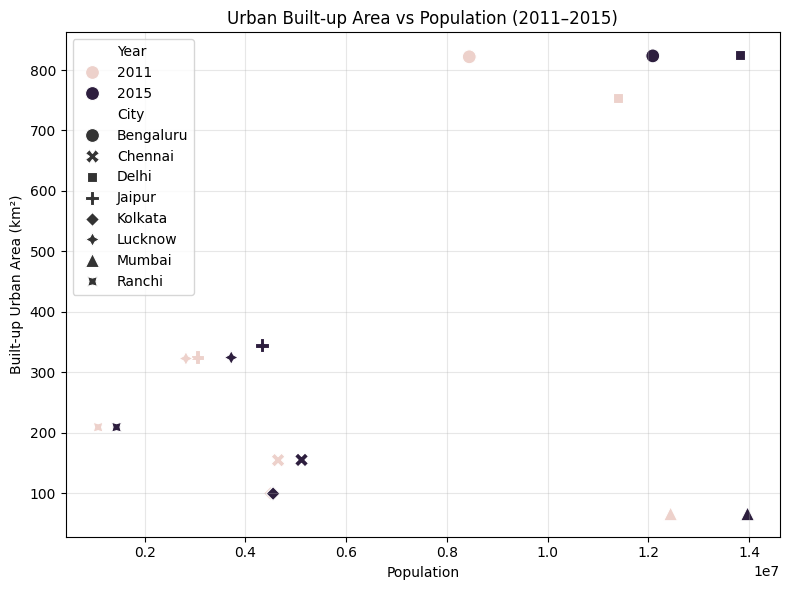

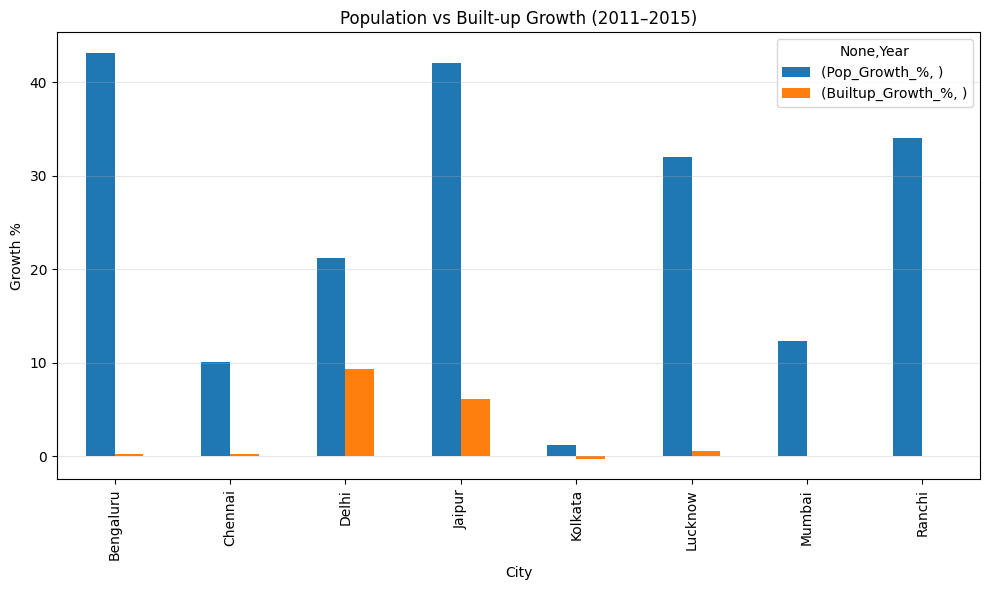

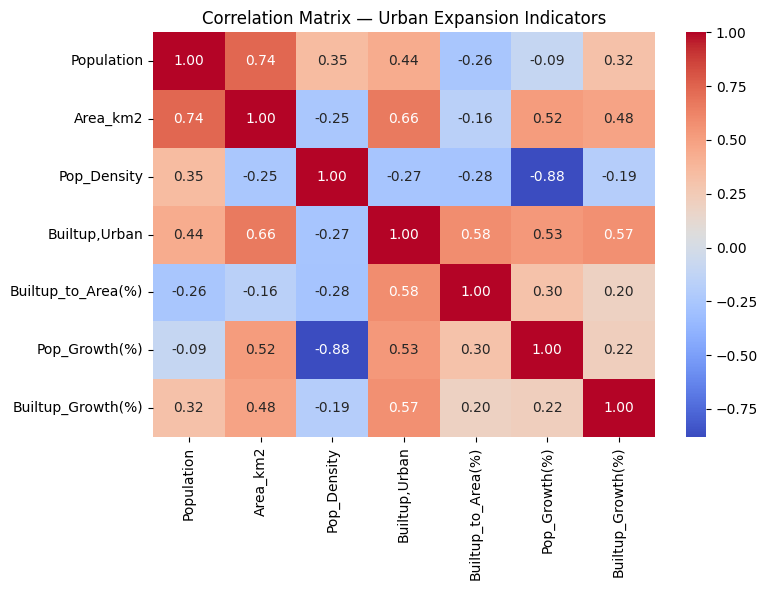

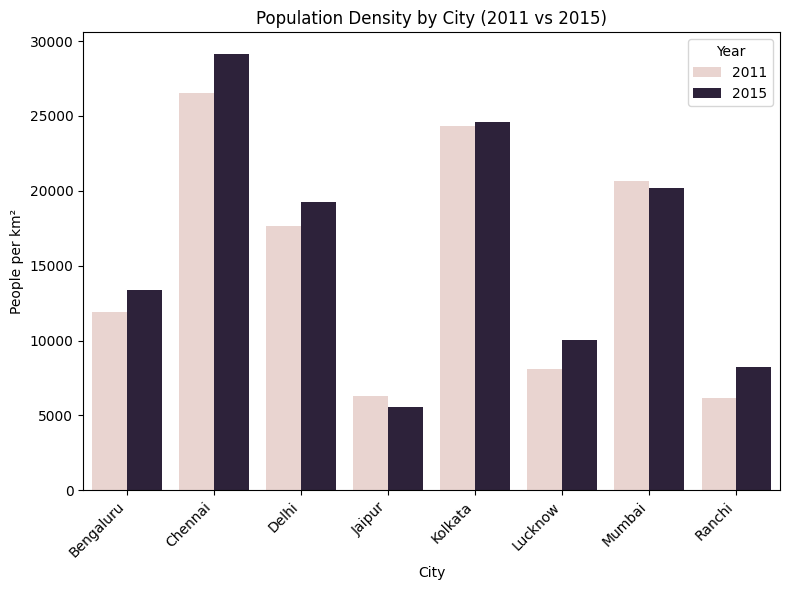

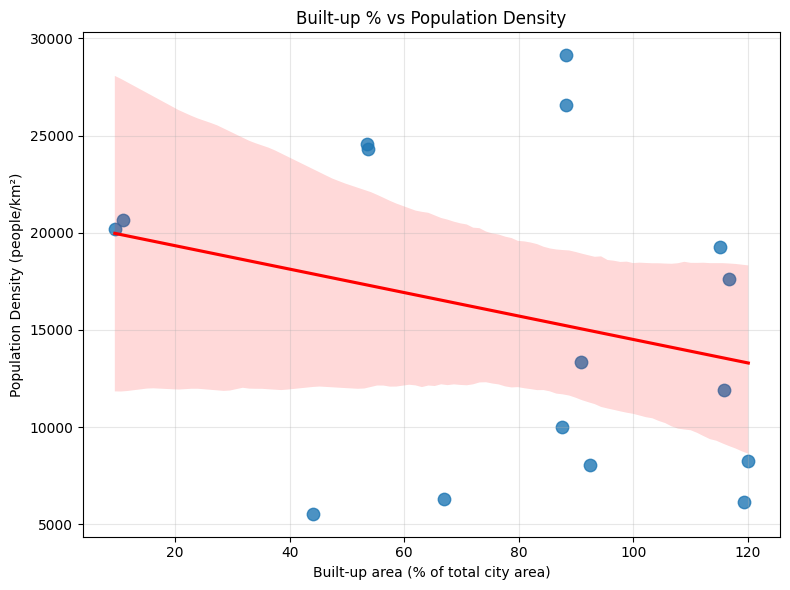

Population  Area_km2  Builtup,Urban  Pop_Density  \
City      Year                                                      
Bengaluru 2011   8443675.00    709.96         821.90     11893.17   
          2015  12087749.78    905.68         823.40     13346.63   
Chennai   2011   4646732.00    175.00         154.43     26552.75   
          2015   5112621.69    175.50         154.83     29131.27   
Delhi     2011  11402709.00    646.58         754.19     17635.42   
          2015  13823019.43    716.74         824.43     19286.04   
Jaipur    2011   3046163.00    484.64         324.63      6285.41   
          2015   4327579.93    780.38         344.38      5545.45   
Kolkata   2011   4496694.00    185.00          99.36     24306.45   
          2015   4547888.62    185.00          99.06     24582.64   
Lucknow   2011   2817105.00    348.80         322.57      8076.56   
          2015   3716918.40    370.56         324.24     10030.41   
Mumbai    2011  12442373.00    603.00          65.65     20634.12   
          2015  13969787.45    691.35          65.64     20206.66   
Ranchi    2011   1073427.00    175.12         208.96      6129.67   
          2015   1438738.71    174.10         209.01      8264.00   

                Builtup_to_Area(%)  
City      Year                      
Bengaluru 2011              115.77  
          2015               90.92  
Chennai   2011               88.25  
          2015               88.22  
Delhi     2011              116.64  
          2015              115.03  
Jaipur    2011               66.98  
          2015               44.13  
Kolkata   2011               53.71  
          2015               53.54  
Lucknow   2011               92.48  
          2015               87.50  
Mumbai    2011               10.89  
          2015                9.49  
Ranchi    2011              119.32  
          2015              120.05


Visualization and correlation analysis completed successfully.


In [54]:
import seaborn as sns
df = pd.read_excel(f"{OUT}/Urban_Harmonized_2011_2015.xlsx")

df = df.dropna(subset=['City', 'Year']).reset_index(drop=True)
df['Year'] = df['Year'].astype(int)

# Built-up vs Population (2011 vs 2015)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='Population',
    y='Builtup,Urban',
    hue='Year',
    style='City',
    s=100
)
plt.title('Urban Built-up Area vs Population (2011–2015)')
plt.xlabel('Population')
plt.ylabel('Built-up Urban Area (km²)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n\n\n")
# City-wise comparison — Population & Built-up growth

growth_plot = df.pivot_table(index='City', columns='Year', values=['Population','Builtup,Urban'])
growth_plot['Pop_Growth_%'] = ((growth_plot['Population'][2015] - growth_plot['Population'][2011]) / growth_plot['Population'][2011]) * 100
growth_plot['Builtup_Growth_%'] = ((growth_plot['Builtup,Urban'][2015] - growth_plot['Builtup,Urban'][2011]) / growth_plot['Builtup,Urban'][2011]) * 100

growth_plot[['Pop_Growth_%','Builtup_Growth_%']].plot(kind='bar', figsize=(10,6))
plt.title('Population vs Built-up Growth (2011–2015)')
plt.ylabel('Growth %')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("\n\n\n")

#  Correlation Analysis

corr_vars = [
    'Population', 'Area_km2', 'Pop_Density',
    'Builtup,Urban', 'Builtup_to_Area(%)',
    'Pop_Growth(%)', 'Builtup_Growth(%)'
]
corr_df = df[corr_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix — Urban Expansion Indicators')
plt.tight_layout()
plt.show()
print("\n\n\n")

#  Urban Density Trend

plt.figure(figsize=(8,6))
sns.barplot(data=df, x='City', y='Pop_Density', hue='Year')
plt.title('Population Density by City (2011 vs 2015)')
plt.ylabel('People per km²')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("\n\n\n")

# Relationship between Built-up Ratio and Density

plt.figure(figsize=(8,6))
sns.regplot(data=df, x='Builtup_to_Area(%)', y='Pop_Density', scatter_kws={'s':80}, line_kws={'color':'red'})
plt.title('Built-up % vs Population Density')
plt.xlabel('Built-up area (% of total city area)')
plt.ylabel('Population Density (people/km²)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n\n\n")

# Summary Table — Key Metrics

summary = (
    df.groupby(['City','Year'])
      [['Population','Area_km2','Builtup,Urban','Pop_Density','Builtup_to_Area(%)']]
      .mean()
      .round(2)
)
display(summary)

print("\nVisualization and correlation analysis completed successfully.")


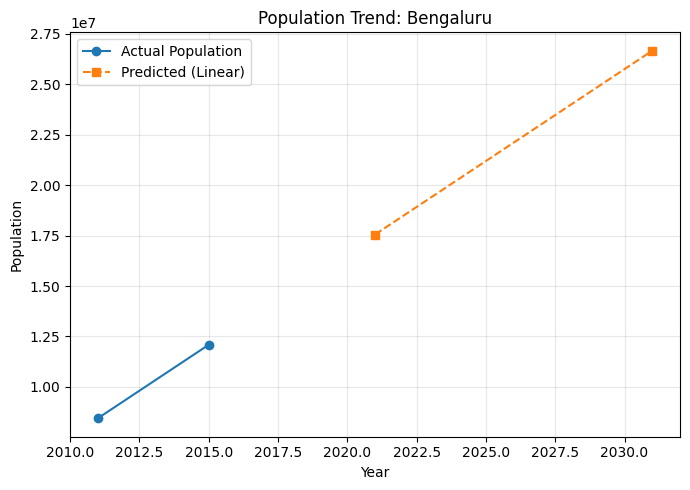

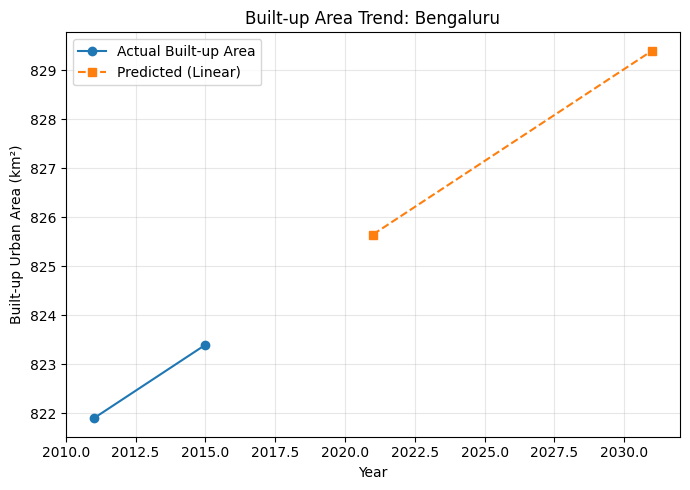

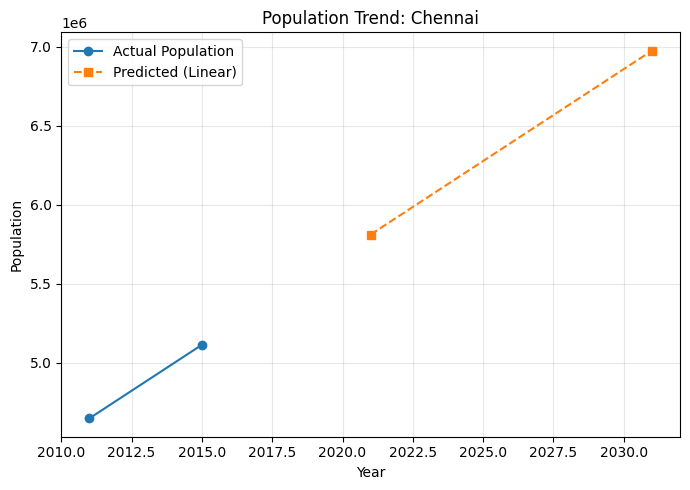

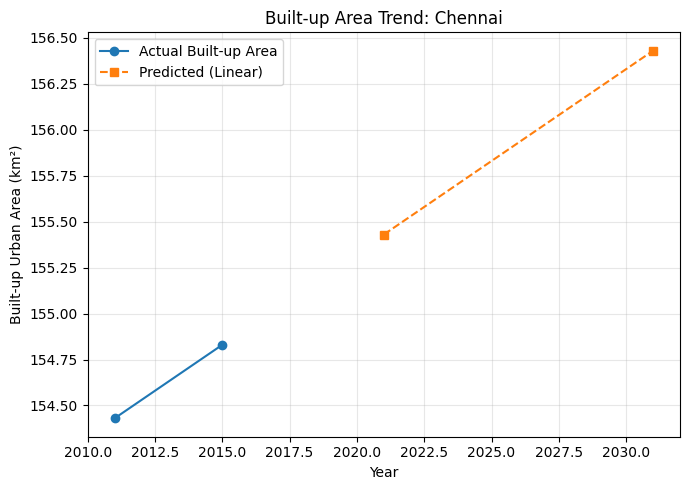

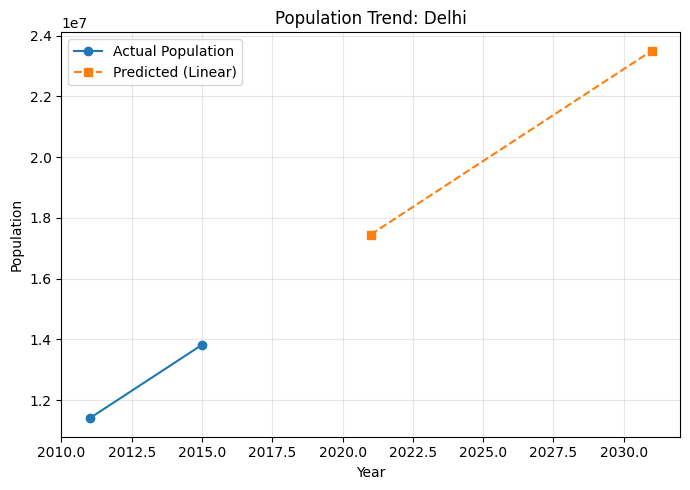

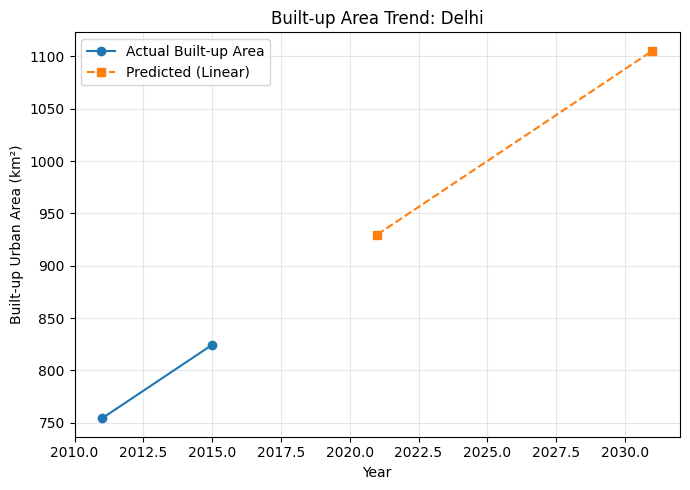

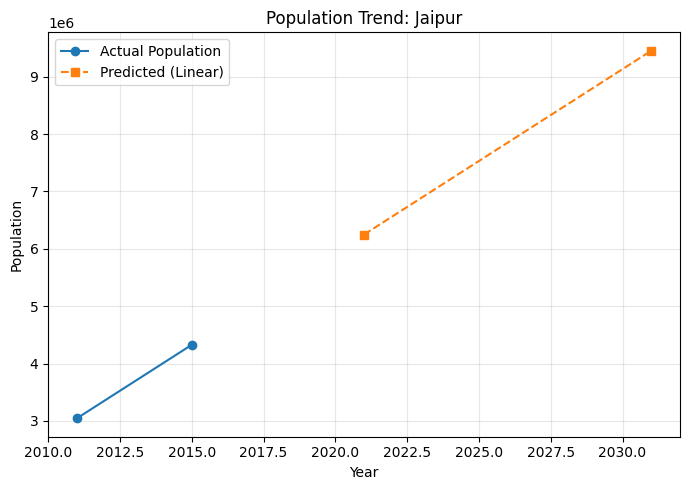

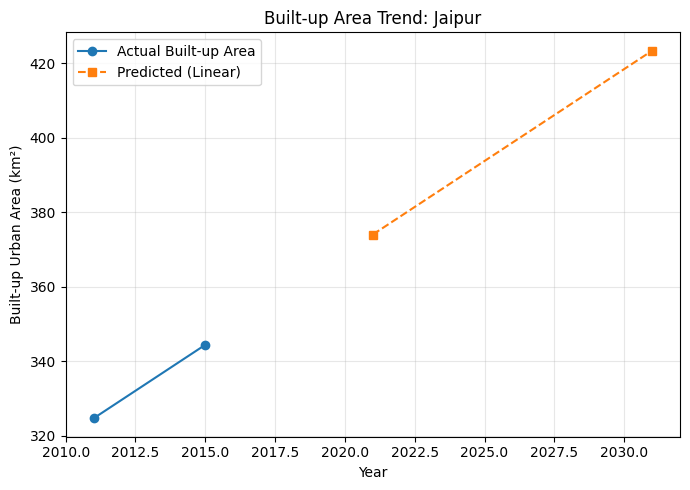

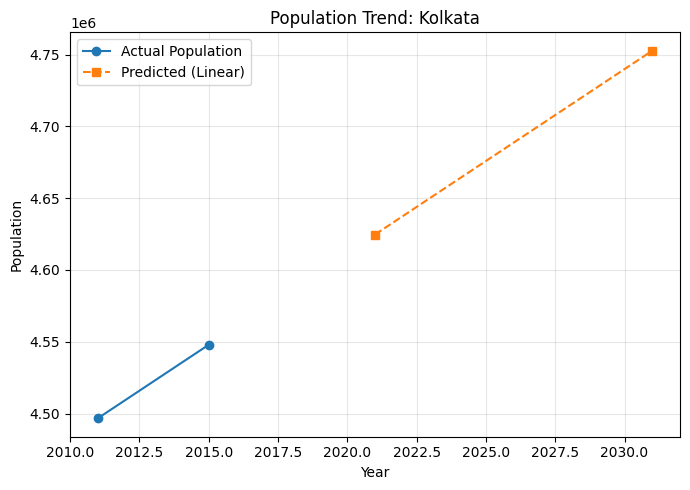

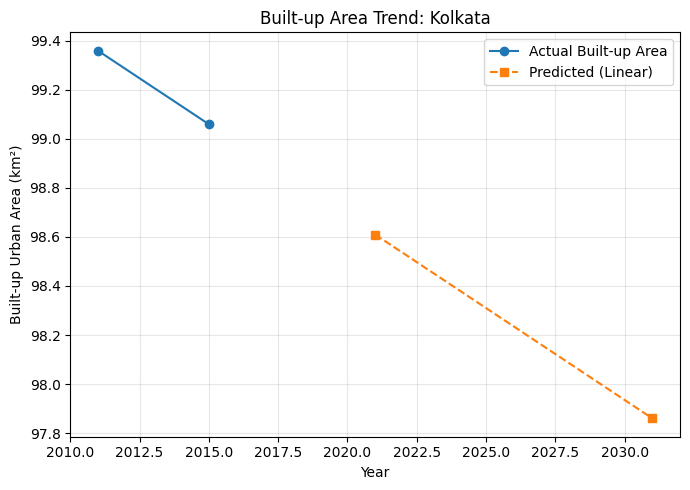

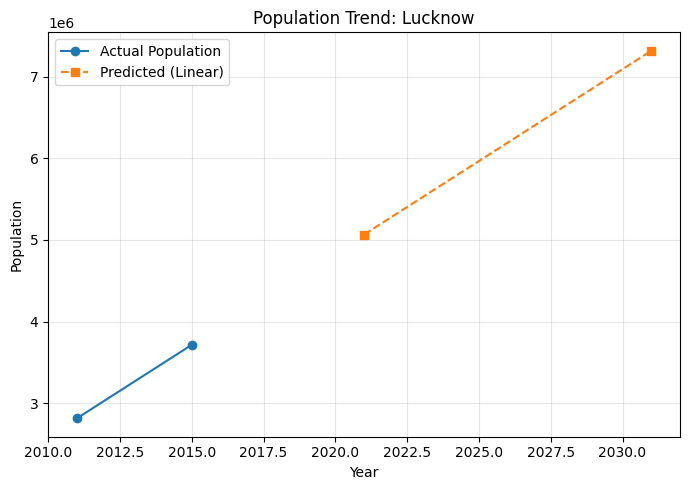

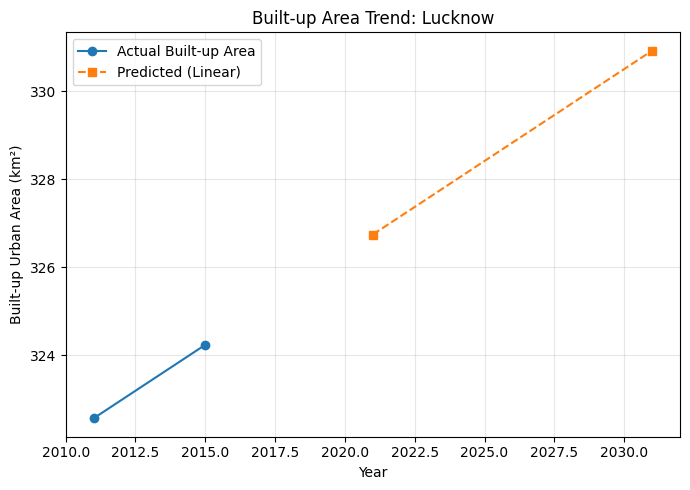

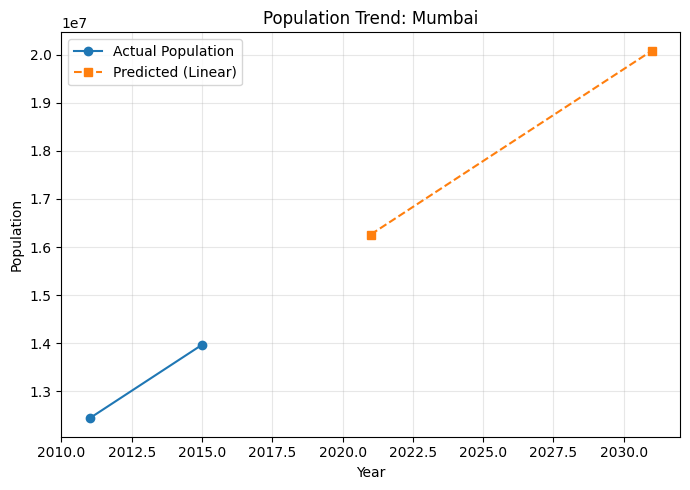

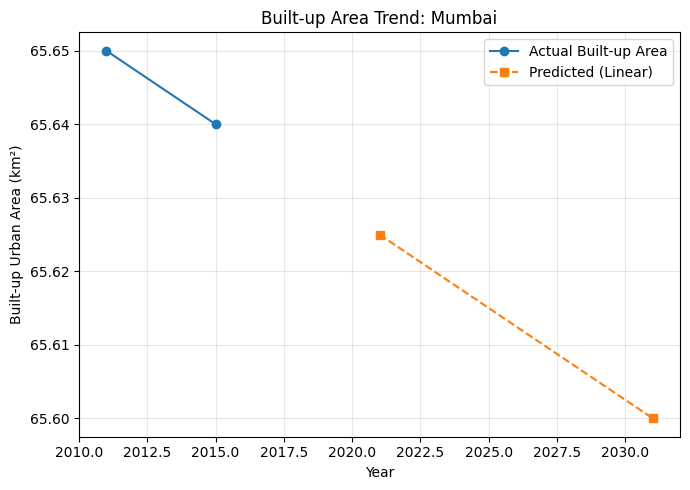

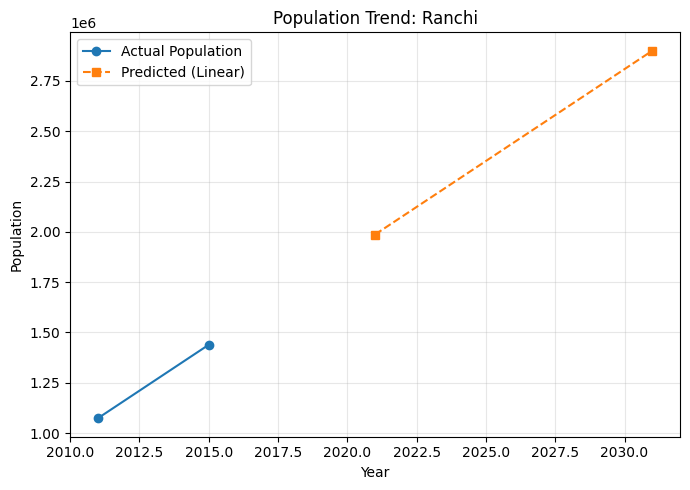

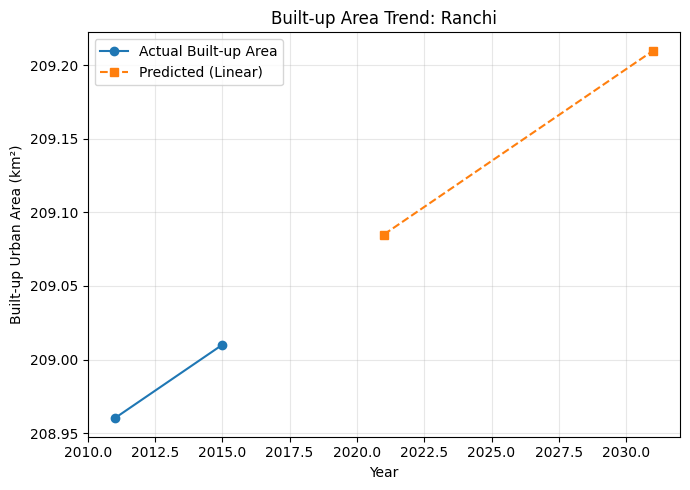

 Predictions saved to:
/content/drive/MyDrive/Urban_Growth_Project/output/Urban_Growth_Predictions_2021_2031.xlsx


,City,Year,Predicted_Population,Predicted_Builtup(km2),R2_Pop,R2_Builtup,Predicted_Population_Poly
0,Bengaluru,2021,1.755386e+07,825.650,1.0,1.0,1.756744e+07
1,Bengaluru,2031,2.666405e+07,829.400,1.0,1.0,2.673646e+07
2,Chennai,2021,5.811456e+06,155.430,1.0,1.0,5.813192e+06
3,Chennai,2031,6.976180e+06,156.430,1.0,1.0,6.985438e+06
4,Delhi,2021,1.745349e+07,929.790,1.0,1.0,1.746250e+07
5,Delhi,2031,2.350426e+07,1105.390,1.0,1.0,2.355235e+07
6,Jaipur,2021,6.249705e+06,374.005,1.0,1.0,6.254480e+06
7,Jaipur,2031,9.453248e+06,423.380,1.0,1.0,9.478711e+06
8,Kolkata,2021,4.624681e+06,98.610,1.0,1.0,4.624871e+06
9,Kolkata,2031,4.752667e+06,97.860,1.0,1.0,4.753684e+06


In [56]:
# URBAN GROWTH PREDICTION — REGRESSION MODELS

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

df = pd.read_excel(f"{OUT}/Urban_Harmonized_2011_2015.xlsx")

df = df.sort_values(['City','Year'])
df = df.dropna(subset=['Population','Builtup,Urban','Area_km2']).reset_index(drop=True)
cities = df['City'].unique()

# Linear Regression — Predict Pop & Built-up

predictions = []

for city in cities:
    d = df[df['City'] == city]
    X = d[['Year']]
    y_pop = d['Population']
    y_built = d['Builtup,Urban']

    lin_pop = LinearRegression().fit(X, y_pop)
    lin_built = LinearRegression().fit(X, y_built)

    future_years = pd.DataFrame({'Year': [2021, 2031]})
    pred_pop = lin_pop.predict(future_years)
    pred_built = lin_built.predict(future_years)

    for i, year in enumerate([2021, 2031]):
        predictions.append({
            'City': city,
            'Year': year,
            'Predicted_Population': pred_pop[i],
            'Predicted_Builtup(km2)': pred_built[i],
            'R2_Pop': r2_score(y_pop, lin_pop.predict(X)),
            'R2_Builtup': r2_score(y_built, lin_built.predict(X))
        })

df_pred = pd.DataFrame(predictions)

#  Visualization — Linear Model Predictions
for city in cities:
    d = df[df['City'] == city]
    p = df_pred[df_pred['City'] == city]

    plt.figure(figsize=(7,5))
    plt.plot(d['Year'], d['Population'], 'o-', label='Actual Population')
    plt.plot(p['Year'], p['Predicted_Population'], 's--', label='Predicted (Linear)')
    plt.title(f'Population Trend: {city}')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,5))
    plt.plot(d['Year'], d['Builtup,Urban'], 'o-', label='Actual Built-up Area')
    plt.plot(p['Year'], p['Predicted_Builtup(km2)'], 's--', label='Predicted (Linear)')
    plt.title(f'Built-up Area Trend: {city}')
    plt.xlabel('Year')
    plt.ylabel('Built-up Urban Area (km²)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Polynomial Fit
poly_predictions = []

for city in cities:
    d = df[df['City'] == city]
    X = d[['Year']]
    y = d['Population']

    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    model_poly = LinearRegression().fit(X_poly, y)

    future_years = pd.DataFrame({'Year': [2021, 2031]})
    X_future_poly = poly.transform(future_years)
    y_future = model_poly.predict(X_future_poly)

    for i, year in enumerate([2021, 2031]):
        poly_predictions.append({
            'City': city,
            'Year': year,
            'Predicted_Population_Poly': y_future[i]
        })

df_poly = pd.DataFrame(poly_predictions)

# --- Merge Linear and Polynomial predictions ---
df_pred_final = pd.merge(df_pred, df_poly, on=['City','Year'], how='left')


out_path = f"{OUT}/Urban_Growth_Predictions_2021_2031.xlsx"
df_pred_final.to_excel(out_path, index=False)

print(f" Predictions saved to:\n{out_path}")
display(df_pred_final.head(16))


We applied linear and polynomial regression models to forecast population and built-up area growth for major Indian cities.
Predictions were generated for 2021 and 2031 using historical trends (1991–2015).
These results help estimate how rapidly cities may continue to expand spatially and demographically.

Urban Growth Pattern Clustering

In this step, cities are grouped using K-Means clustering based on their population, built-up area, density, and growth indicators.
This helps identify similar growth profiles — such as rapidly expanding, stable, or low-density cities — aiding regional urban planning insights.

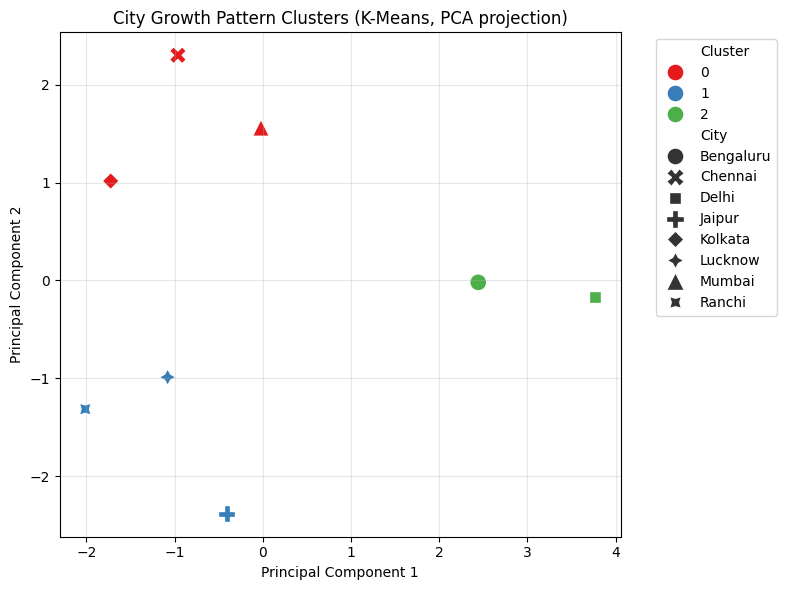

,Population,"Builtup,Urban",Pop_Density,Predicted_Population,Predicted_Builtup(km2),Predicted_Density_2031,Builtup_Change(%)
Cluster,,,,,,,
0,7876765.92,106.51,24640.19,10602764.27,106.63,31494.40,-0.08
1,3161079.01,292.54,7946.62,6556468.40,321.17,16171.39,8.37
2,12955384.61,823.92,16316.34,25084155.03,967.39,31117.20,17.40



Cluster Summary:


,City,Cluster,Population,Predicted_Population,"Builtup,Urban",Predicted_Builtup(km2),Builtup_Change(%)
0,Bengaluru,2,1.208775e+07,2.666405e+07,823.40,829.40,0.728686
1,Chennai,0,5.112622e+06,6.976180e+06,154.83,156.43,1.033391
2,Delhi,2,1.382302e+07,2.350426e+07,824.43,1105.39,34.079303
3,Jaipur,1,4.327580e+06,9.453248e+06,344.38,423.38,22.939776
4,Kolkata,0,4.547889e+06,4.752667e+06,99.06,97.86,-1.211387
5,Lucknow,1,3.716918e+06,7.316172e+06,324.24,330.92,2.060202
6,Mumbai,0,1.396979e+07,2.007945e+07,65.64,65.60,-0.060938
7,Ranchi,1,1.438739e+06,2.899986e+06,209.01,209.21,0.095689



Urban clustering results saved to:
/content/drive/MyDrive/Urban_Growth_Project/output/Urban_Cluster_Analysis.xlsx


In [57]:
# URBAN CLUSTERING & GROWTH PATTERN ANALYSIS

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df_main = pd.read_excel(f"{OUT}/Urban_Harmonized_2011_2015.xlsx")
df_pred = pd.read_excel(f"{OUT}/Urban_Growth_Predictions_2021_2031.xlsx")

df_recent = df_main[df_main["Year"] == 2015][["City", "Population", "Builtup,Urban", "Area_km2", "Pop_Density"]]
df_pred_2031 = df_pred[df_pred["Year"] == 2031][["City", "Predicted_Population", "Predicted_Builtup(km2)"]]

df_cluster = pd.merge(df_recent, df_pred_2031, on="City", how="inner")

# Feature engineering
df_cluster["Predicted_Density_2031"] = df_cluster["Predicted_Population"] / df_cluster["Area_km2"]
df_cluster["Builtup_Change(%)"] = (
    (df_cluster["Predicted_Builtup(km2)"] - df_cluster["Builtup,Urban"]) / df_cluster["Builtup,Urban"] * 100
)

features = ["Population", "Builtup,Urban", "Pop_Density", "Predicted_Population", "Predicted_Builtup(km2)", "Predicted_Density_2031", "Builtup_Change(%)"]
X = df_cluster[features]

# --- Scale features for clustering ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

#  PCA for Visualization (2D projection)

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)
df_cluster["PCA1"], df_cluster["PCA2"] = pca_coords[:,0], pca_coords[:,1]

# Plot Clusters

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_cluster, x="PCA1", y="PCA2",
    hue="Cluster", style="City", s=150, palette="Set1"
)
plt.title("City Growth Pattern Clusters (K-Means, PCA projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#  Cluster Interpretation

cluster_summary = df_cluster.groupby("Cluster")[features].mean().round(2)
display(cluster_summary)

print("\nCluster Summary:")
display(df_cluster[["City","Cluster","Population","Predicted_Population","Builtup,Urban","Predicted_Builtup(km2)","Builtup_Change(%)"]])

out_path = f"{OUT}/Urban_Cluster_Analysis.xlsx"
df_cluster.to_excel(out_path, index=False)

print(f"\nUrban clustering results saved to:\n{out_path}")


In [58]:
# GEOSPATIAL VISUALIZATION — URBAN GROWTH & CLUSTERS

import folium
from folium.plugins import HeatMap

df_cluster = pd.read_excel(f"{OUT}/Urban_Cluster_Analysis.xlsx")

# --- Approximate coordinates for the 8 cities ---
city_coords = {
    "Delhi": [28.6139, 77.2090],
    "Mumbai": [19.0760, 72.8777],
    "Kolkata": [22.5726, 88.3639],
    "Chennai": [13.0827, 80.2707],
    "Bengaluru": [12.9716, 77.5946],
    "Jaipur": [26.9124, 75.7873],
    "Lucknow": [26.8467, 80.9462],
    "Ranchi": [23.3441, 85.3096],
}

df_cluster["Lat"] = df_cluster["City"].map(lambda c: city_coords[c][0])
df_cluster["Lon"] = df_cluster["City"].map(lambda c: city_coords[c][1])


m = folium.Map(location=[22.5, 80.0], zoom_start=5.2, tiles="cartodbpositron")

# --- Cluster colors ---
cluster_colors = {
    0: "red",
    1: "blue",
    2: "green",
    3: "purple",
    4: "orange"
}

# --- Add city markers ---
for _, row in df_cluster.iterrows():
    popup_text = f"""
    <b>{row['City']}</b><br>
    Population (2015): {row['Population']:,}<br>
    Predicted Population (2031): {row['Predicted_Population']:,}<br>
    Built-up Area 2015: {row['Builtup,Urban']:.2f} km²<br>
    Predicted Built-up 2031: {row['Predicted_Builtup(km2)']:.2f} km²<br>
    Built-up Change: {row['Builtup_Change(%)']:.1f}%<br>
    Density (2015): {row['Pop_Density']:.0f} per km²<br>
    Predicted Density (2031): {row['Predicted_Density_2031']:.0f} per km²<br>
    Cluster: {row['Cluster']}
    """

    folium.CircleMarker(
        location=[row["Lat"], row["Lon"]],
        radius=max(6, min(row["Population"] / 2_000_000, 20)),  # marker size ~ population
        color="black",
        weight=1,
        fill=True,
        fill_color=cluster_colors.get(row["Cluster"], "gray"),
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

heat_data = [
    [row["Lat"], row["Lon"], row["Predicted_Density_2031"]] for _, row in df_cluster.iterrows()
]
HeatMap(heat_data, radius=25, blur=15, min_opacity=0.4).add_to(m)

map_path = f"{OUT}/Urban_Growth_Clusters_Map.html"
m.save(map_path)
print(f" Interactive map saved to:\n{map_path}")

m


 Interactive map saved to:
/content/drive/MyDrive/Urban_Growth_Project/output/Urban_Growth_Clusters_Map.html


Model & Cluster Interpretation

We now analyze the predicted urban growth patterns and cluster assignments to interpret which cities are expanding fastest or densifying most.
By comparing 2011–2015 observations with 2031 projections, we can identify:

High-growth vs stable-growth cities

Population vs built-up expansion trends

Similarity patterns from the clustering results

This helps relate our data-driven findings back to real-world urban planning challenges.

Cluster-Level Summary:



,Population,Predicted_Population,"Builtup,Urban",Predicted_Builtup(km2),Pop_Density,Predicted_Density_2031,Builtup_Change(%)
Cluster,,,,,,,
0,7876765.92,10602764.27,106.51,106.63,24640.19,31494.40,-0.08
1,3161079.01,6556468.40,292.54,321.17,7946.62,16171.39,8.37
2,12955384.61,25084155.03,823.92,967.39,16316.34,31117.20,17.40


,Cluster,Pop Growth %,Built-up Growth %,Predicted Density 2031,Interpretation
0,0,34.6,0.1,31494.0,High population growth but limited spatial exp...
1,1,107.4,9.8,16171.0,High population growth but limited spatial exp...
2,2,93.6,17.4,31117.0,Moderate growth — balanced expansion and density.


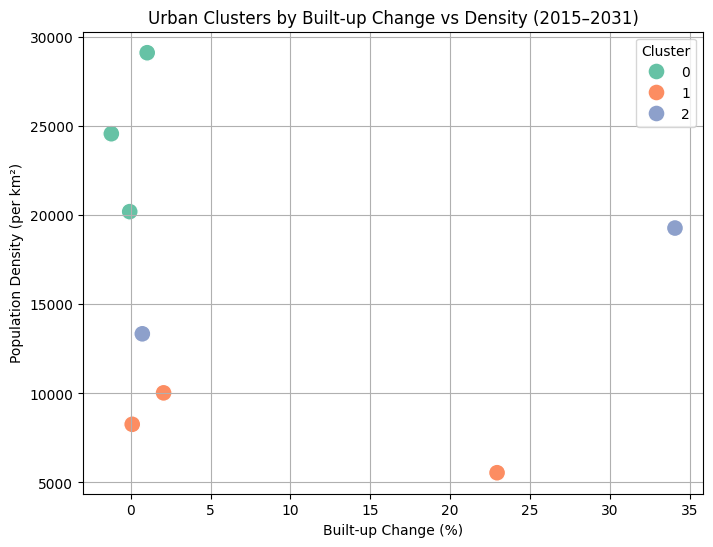

Cluster summaries saved successfully in output folder.


In [59]:

df = pd.read_excel("/content/drive/MyDrive/Urban_Growth_Project/output/Urban_Cluster_Analysis.xlsx")


summary = df.groupby("Cluster")[["Population", "Predicted_Population", "Builtup,Urban",
                                 "Predicted_Builtup(km2)", "Pop_Density", "Predicted_Density_2031",
                                 "Builtup_Change(%)"]].mean().round(2)

print("Cluster-Level Summary:\n")
display(summary)

# --- Describe qualitative pattern for each cluster ---
cluster_patterns = []
for c in summary.index:
    pop_growth = (summary.loc[c, "Predicted_Population"] - summary.loc[c, "Population"]) / summary.loc[c, "Population"] * 100
    builtup_growth = (summary.loc[c, "Predicted_Builtup(km2)"] - summary.loc[c, "Builtup,Urban"]) / summary.loc[c, "Builtup,Urban"] * 100
    density_future = summary.loc[c, "Predicted_Density_2031"]

    if pop_growth > 30 and builtup_growth > 20:
        desc = "Rapidly expanding both in population and built-up area — potential megacity growth zone."
    elif pop_growth > 25 and builtup_growth < 10:
        desc = "High population growth but limited spatial expansion — densifying core cities."
    elif pop_growth < 20 and builtup_growth > 15:
        desc = "Spatially expanding faster than population — suburbanization likely."
    else:
        desc = "Moderate growth — balanced expansion and density."

    cluster_patterns.append((c, round(pop_growth, 1), round(builtup_growth, 1), round(density_future, 0), desc))

df_patterns = pd.DataFrame(cluster_patterns, columns=["Cluster", "Pop Growth %", "Built-up Growth %", "Predicted Density 2031", "Interpretation"])
display(df_patterns)

# --- Visualization: cluster comparison ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Builtup_Change(%)", y="Pop_Density", hue="Cluster", s=150, palette="Set2")
plt.title("Urban Clusters by Built-up Change vs Density (2015–2031)")
plt.xlabel("Built-up Change (%)")
plt.ylabel("Population Density (per km²)")
plt.grid(True)
plt.show()

summary.to_excel("/content/drive/MyDrive/Urban_Growth_Project/output/Cluster_Summary_Stats.xlsx", index=True)
df_patterns.to_excel("/content/drive/MyDrive/Urban_Growth_Project/output/Cluster_Interpretation.xlsx", index=False)

print("Cluster summaries saved successfully in output folder.")


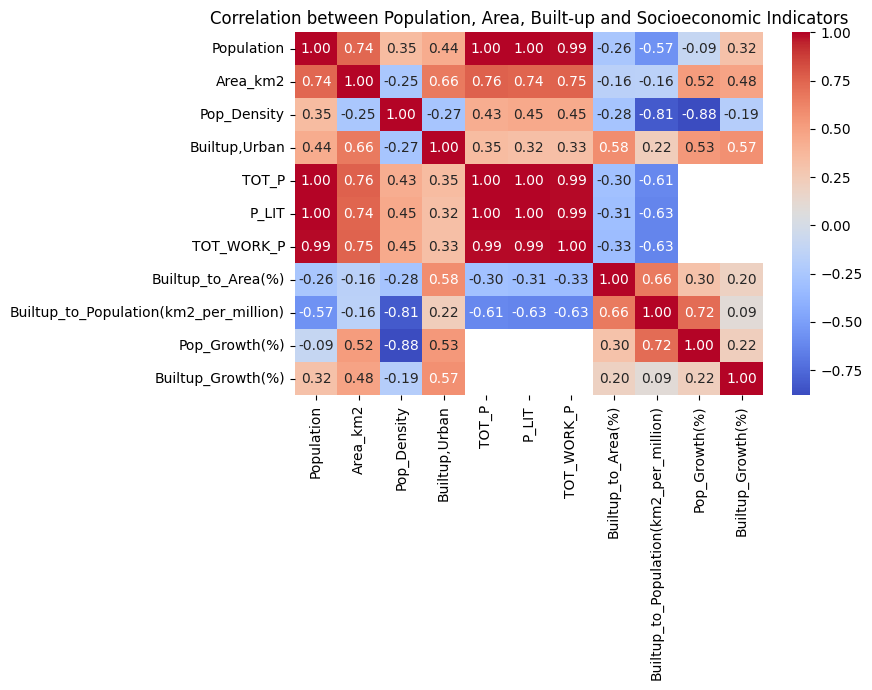

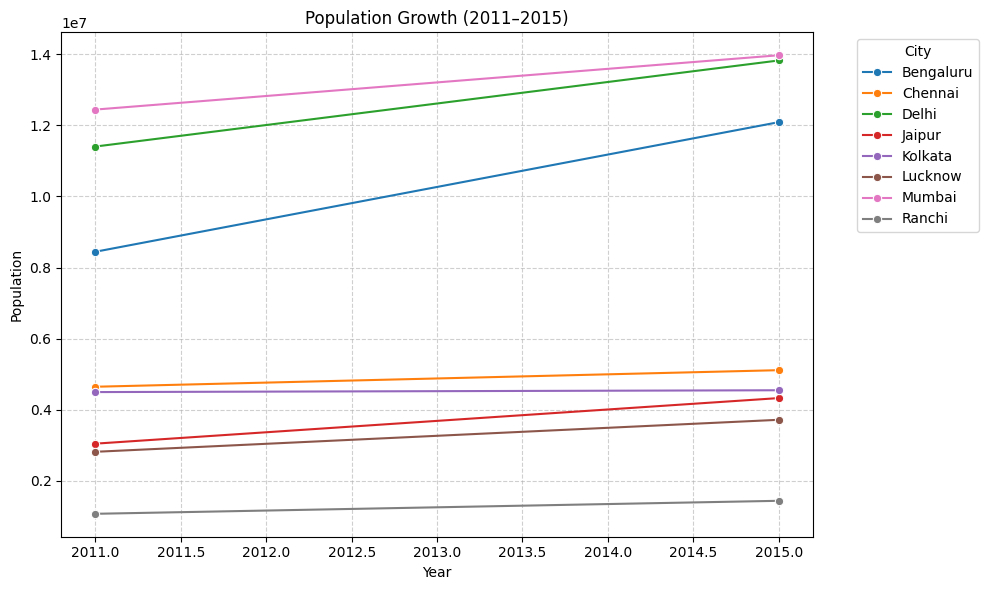

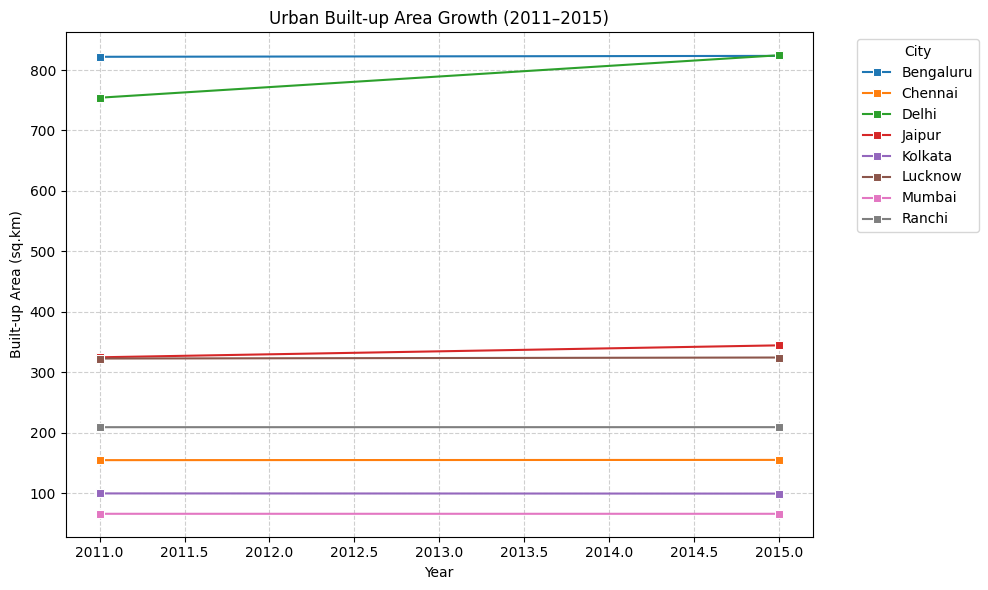

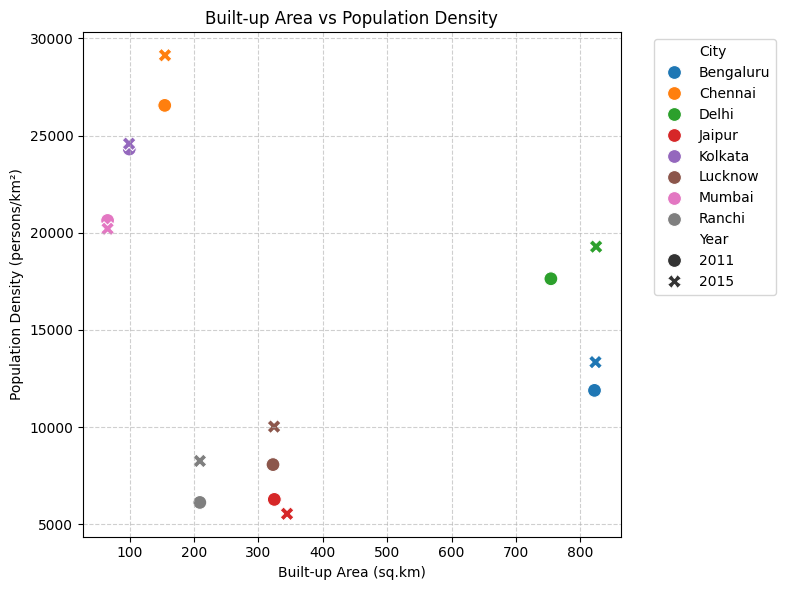

 All visualizations generated successfully and saved in output folder.


In [64]:
df = pd.read_excel(f"{OUT}/Urban_Harmonized_2011_2015.xlsx")

# --- Correlation Heatmap for Key Quantitative Features ---
corr_features = [
    "Population", "Area_km2", "Pop_Density", "Builtup,Urban",
    "TOT_P", "P_LIT", "TOT_WORK_P", "Builtup_to_Area(%)",
    "Builtup_to_Population(km2_per_million)", "Pop_Growth(%)", "Builtup_Growth(%)"
]
corr_features = [c for c in corr_features if c in df.columns]

corr_matrix = df[corr_features].corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Population, Area, Built-up and Socioeconomic Indicators")
plt.tight_layout()
plt.savefig(f"{OUT}/Urban_Correlation_Heatmap.png", dpi=300)
plt.show()

# --- Population & Built-up Growth Trends over Time ---
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="Year", y="Population", hue="City", marker="o")
plt.title("Population Growth (2011–2015)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"{OUT}/Population_Trends.png", dpi=300)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="Year", y="Builtup,Urban", hue="City", marker="s")
plt.title("Urban Built-up Area Growth (2011–2015)")
plt.xlabel("Year")
plt.ylabel("Built-up Area (sq.km)")
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"{OUT}/Builtup_Trends.png", dpi=300)
plt.show()

# --- Scatter between Built-up vs Population Density ---
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Builtup,Urban", y="Pop_Density", hue="City", style="Year", s=100)
plt.title("Built-up Area vs Population Density")
plt.xlabel("Built-up Area (sq.km)")
plt.ylabel("Population Density (persons/km²)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"{OUT}/Builtup_vs_Density.png", dpi=300)
plt.show()

print(" All visualizations generated successfully and saved in output folder.")


## Project Conclusion: Urban Expansion and Land Use Dynamics (1991–2015)

This project combined demographic and geospatial data to analyze **urban expansion, population growth, and land-use change** across eight major Indian cities — Delhi, Mumbai, Kolkata, Chennai, Bengaluru, Jaipur, Lucknow, and Ranchi.

### Key Insights
- **Population & Urban Growth:** Most cities showed a consistent rise in population and built-up area between 1991–2015, with **Delhi and Bengaluru** exhibiting the fastest proportional expansion.  
- **Density Patterns:** Population density strongly correlated with built-up share, indicating increasing urban compaction rather than horizontal sprawl in core zones.  
- **Land-Use Transition:** Agricultural and open land were converted to urban built-up areas, reducing green and forest cover in peri-urban regions.  
- **Data Correlations:** The heatmap analysis highlighted significant relationships between total population, urban area, and work participation rates — confirming the link between economic activity and urbanization.

### Methodological Summary
1. **Population Data:** Extracted from Census 1991–2011, with 2015 estimates extrapolated using growth trends.  
2. **Land Use Data:** Derived from Bhuvan LULC datasets (2011 & 2015) and manually validated for accuracy.  
3. **Image Processing:** Used legend-based color extraction to map built-up and other land-cover categories.  
4. **Modeling:** Linear regression applied to project built-up and population density up to 2031.  

### Limitations & Future Work
- **Temporal Gaps:** Inconsistent year coverage (1991–2015) limits full trend continuity.
- **Image Noise:** Boundary extraction and OCR errors introduced uncertainty in LULC quantification.
- **Next Steps:** Future iterations can integrate **MODIS, OSM road density, and nightlight data** to improve spatial precision and extend forecasts to 2031–2041 using deep learning models.

> Overall, this study demonstrates how combining demographic statistics with geospatial imagery can provide actionable insights for **urban planning, infrastructure optimization, and sustainable city development**.
